In [14]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 440e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)

18.389524275269295 arcsec
0.08794700560103402


In [7]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [5]:
npsf = 100
cam.set_roi(570, 900, npsf, client0)

In [6]:
cam.set_exptime(0.0001, client0)

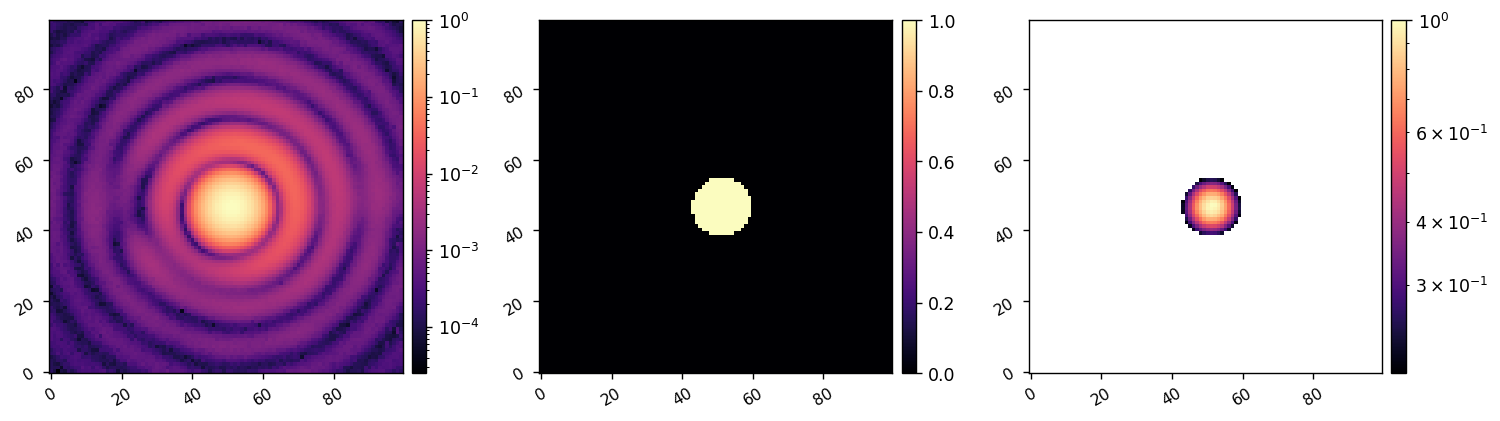

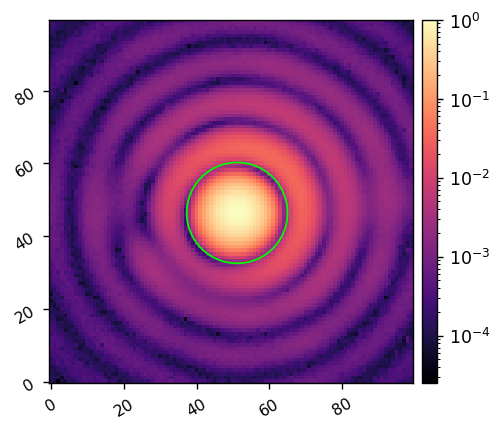

In [15]:
cam.Nframes = 1000
im = cam.snap()

reload(utils)
cen = utils.centroid(im, thresh=0.2, plot=True)
imshow1(im, lognorm=True, patches=[Circle(cen, 1.22 * 1/pxscl_lamD, fill=False, color='lime')])


In [16]:
fsm = ImageStream('fsm')

In [17]:
fsm.write(v_bias)

# Make FSM do a circle

In [28]:
amp = 1*as_per_lamD

freq = 1*u.Hz
t_max = (1/freq).to(u.s)
Nsamps = 19
# Nsamps = 37
times = np.linspace(0, t_max, Nsamps)
delt = (times[1]-times[0]).to_value(u.s)

tip_wave = amp*np.sin(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
tilt_wave = amp*np.cos(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
volt_commands = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=tip_wave[i], tilt=tilt_wave[i])

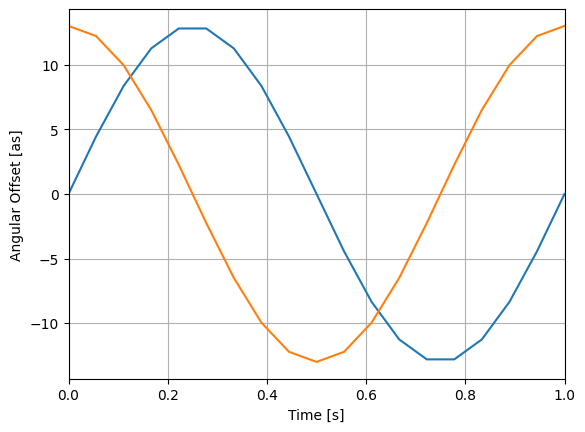

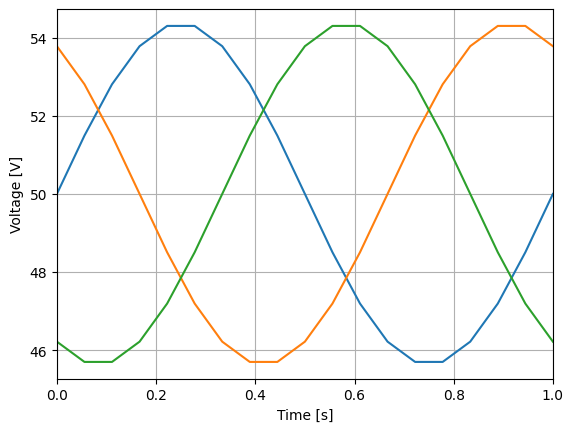

In [29]:
import matplotlib.pyplot as plt
plt.plot(times, tip_wave)
plt.plot(times, tilt_wave)
plt.xlim([0, t_max.to_value(u.s)])
plt.xlabel('Time [s]')
plt.ylabel('Angular Offset [as]')
plt.grid()
plt.show()

plt.plot(times, volt_commands[:,0])
plt.plot(times, volt_commands[:,1])
plt.plot(times, volt_commands[:,2])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.xlim([0, t_max.to_value(u.s)])
plt.grid()
plt.show()

In [30]:
freq = 1 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    while i<Nsamps+1:
        if i==Nsamps-1:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
        # print(i)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)

Modulating FSM ...
FSM modulation stopped!


In [33]:
fsm.write(0*v_bias)